[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

LANGCHAIN_API_KEY:  ········


## Messages as state

First, let's define some messages.

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [HumanMessage(f"I am researching in ocean mammals.", name="Lance")]
messages.append(AIMessage(f"So you said you were researching ocean mammals?", name="Bot"))
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

I am researching in ocean mammals.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [7]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o")

from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    model_kwargs=dict(temperature=0),
    # other params...
)

llm.invoke(messages)

AIMessage(content="Here are some other major groups of ocean mammals you may want to research and learn about:\n\n- Pinnipeds - This includes seals, sea lions, and walruses. There are many different species found in various ocean environments around the world.\n\n- Sirenians - This order includes manatees and dugongs, which are large herbivorous marine mammals.\n\n- Marine Otters - Such as the sea otter, which lives in the coastal waters of the northern Pacific Ocean.\n\n- Polar Bears - While not fully aquatic, polar bears are excellent swimmers and spend a lot of time hunting in Arctic waters.\n\n- Cetaceans - In addition to the whales you mentioned, this order also includes dolphins and porpoises.\n\n- Sea Cows - The dugong is the only strictly marine herbivorous mammal still living today.\n\n- Marine Mustelids - Such as sea otters and marine weasels that live part of their life in the ocean.\n\nI'd recommend focusing on their evolution, anatomy, behaviors, habitats, conservation sta

We can run our chat model in a simple graph with `MessagesState`.

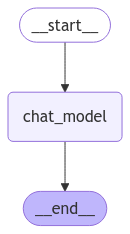

In [8]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

I am researching in ocean mammals.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Here are some other major groups of ocean mammals you may want to research and learn about:

- Pinnipeds - This includes seals, sea lions, and walruses. There are many different species found in various ocean environments around the world.

- Sirenians - This order includes manatees and dugongs, which are large herbivorous marine mammals.

- Polar Bears - While not fully aquatic, polar bears are excellent swimmers and spend a lot of time in the Arctic ocean hunting seals and other marin

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

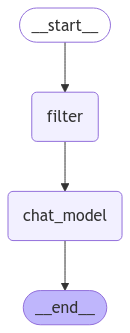

In [10]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages = []

In [25]:
# Message list with a preamble
messages = [HumanMessage(f"Hi.", name="Lance", id="1")]
messages.append(AIMessage(f"Hi.", name="Bot", id="2"))
messages.append(HumanMessage(f"I am researching on oceans mammals.", name="Lance", id="3"))
messages.append(AIMessage(f"So you said you were researching ocean mammals?", name="Bot", id="4"))
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance", id="5"))
messages.append(AIMessage(f"Ok, I will tell about these animals in depth.", name="Bot", id="6"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

Ok, I will tell about these animals in depth.
================================== Ai Message ==================================



Here are some other fascinating animals you could learn about:

1. Elephants - The largest land animals on Earth. They are highly intelligent, have incredible memory, mourn their dead, and live in close-knit matriarchal family groups.

2. Octopuses - These marine mollusks are amazingly intelligent invertebrates. They have complex brains, can use tools, change colors, and contort their bodies to squeeze into tiny spaces.

3. Chimpanzees - Our closest genetic relatives in the animal kingdom. Chimps are highly social, can use tools, have complex communication, and show evidence of self-awareness.

4. Monarch Butterf

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

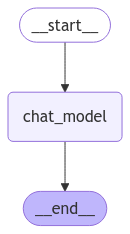

In [26]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [27]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [28]:
for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

I am researching on oceans mammals.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

Ok, I will tell about these animals in depth.
================================== Ai Message ==================================



Here are some other fascinating animals you could learn about:

1. Elephants - The largest land animals on Earth. They are highly intelligent, have incredib

In [14]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

In [38]:
from langchain_aws.llms.bedrock import BedrockLLM

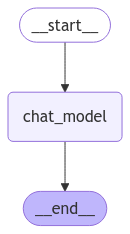

In [39]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=BedrockLLM(model_id="anthropic.claude-3-sonnet-20240229-v1:0"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [ ]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

In [36]:
!pip install anthropic

  Obtaining dependency information for anthropic from https://files.pythonhosted.org/packages/cb/18/a68cfb9a11990377650c36c25b5dfb0baece900e9e505b68e1aa06ad0227/anthropic-0.40.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/199.5 kB ? eta -:--:--
   -------- ------------------------------ 41.0/199.5 kB 991.0 kB/s eta 0:00:01
   ------------------------ --------------- 122.9/199.5 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 199.5/199.5 kB 1.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

ValidationError: 1 validation error for BedrockLLM
  Value error, Claude v3 models are not supported by this LLM.Please use `from langchain_aws import ChatBedrock` instead. [type=value_error, input_value={'model_id': 'anthropic.c...3-sonnet-20240229-v1:0'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r